In [1]:
import sys; sys.path.insert(0, "..")
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('./data/train_A.tsv', delimiter="\t")
df.head()

,user_id,product_id,event_type,ad,time_stamp
0,0000000_A,00009250_a,1,-1,2017-04-08 12:09:04.629
1,0000000_A,00009250_a,1,-1,2017-04-27 12:55:57.783
2,0000000_A,00014068_a,1,-1,2017-04-08 11:57:53.746
3,0000000_A,00001254_a,1,-1,2017-04-08 12:04:26.008
4,0000000_A,00003316_a,1,-1,2017-04-08 12:05:31.326


In [3]:
df = df.sort_values(by=["user_id", "product_id"])
df = df[df["ad"]!=0]
df["event_type"] = df["event_type"].astype(float)

In [4]:
action_count = df.groupby(["user_id", "product_id"]).size().values
action_count

array([1, 1, 1, ..., 2, 5, 3])

In [5]:
# タイムスタンプは一番最新
action_df = df.sort_values(by=["user_id", "product_id", "time_stamp"],ascending=[True, True, False]).drop_duplicates(["user_id", "product_id"])
action_df["action_count"] = action_count
action_df = action_df[action_df["event_type"] != 0.0]

In [6]:
# ユーザ数を100人に絞る(ぼくのmacのスペック、、)
# num_users = 100
# valid_user_ids = sorted(action_df.user_id.unique())[:num_users]
# action_df = action_df[action_df.user_id <= max(valid_user_ids)]

In [7]:
# 学習用とテスト用にデータを分割
# 各ユーザの直近5件の映画を評価用に使い、それ以外を学習用にする
action_df["time_stamp"] = pd.to_datetime(action_df["time_stamp"])
action_df["rating_order"] = action_df.groupby("user_id")["time_stamp"].rank(ascending=False, method="first")
train_df = action_df[action_df["rating_order"] > 5]
test_df = action_df[action_df["rating_order"] <= 5]

In [8]:
minmum_num_rating = 0
filtered_train_df = train_df.groupby("product_id").filter(lambda x: len(x["product_id"]) >= minmum_num_rating)

<AxesSubplot:title={'center':'action_count'}, xlabel='event_type'>

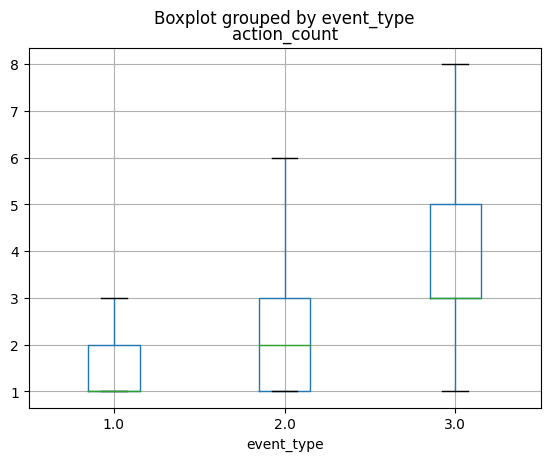

In [9]:
import matplotlib.pyplot as plt

# event_typeごとのaction_countの箱ひげ図
filtered_train_df.boxplot(by="event_type", column="action_count", sym="")

array([[<AxesSubplot:title={'center':'1.0'}>,
        <AxesSubplot:title={'center':'2.0'}>],
       [<AxesSubplot:title={'center':'3.0'}>, <AxesSubplot:>]],
      dtype=object)

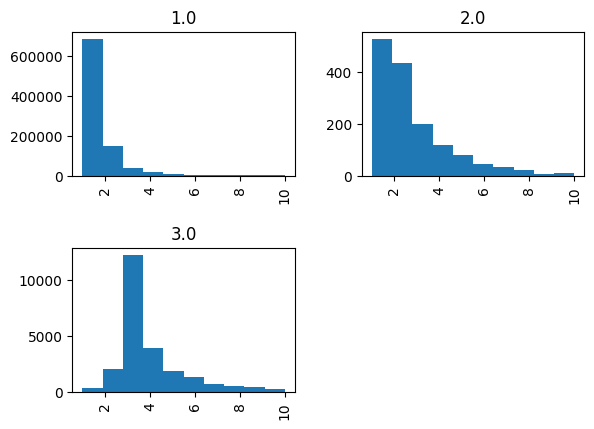

In [10]:
# ヒストグラム
filtered_train_df.hist(by="event_type", column="action_count", range=(1, 10))

In [11]:
unique_user_ids = sorted(action_df.user_id.unique())
unique_product_ids = sorted(action_df.product_id.unique())
user_id2index = dict(zip(unique_user_ids, range(len(unique_user_ids))))
product_id2index = dict(zip(unique_product_ids, range(len(unique_product_ids))))

In [28]:
len(unique_user_ids)

50586

In [12]:
from scipy.sparse import lil_matrix
alpha = 1.0

matrix = lil_matrix((len(unique_product_ids), len(unique_user_ids)))
for i, row in filtered_train_df.iterrows():
    user_index = user_id2index[row["user_id"]]
    product_index = product_id2index[row["product_id"]]
    matrix[product_index, user_index] = row["action_count"]*alpha
matrix

<13763x50586 sparse matrix of type '<class 'numpy.float64'>'
	with 951563 stored elements in List of Lists format>

In [13]:
import implicit
# 因子数
factors = 10
# エポック数
n_epochs = 50

# モデルの初期化
model = implicit.als.AlternatingLeastSquares(
    factors=factors, iterations=n_epochs, calculate_training_loss=True, random_state=1
)

In [14]:
# 学習
model.fit(matrix)

  0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
from collections import defaultdict

# 推薦
recommendations = model.recommend_all(matrix.T)

  0%|          | 0/50586 [00:00<?, ?it/s]

In [77]:
pred_user2items = defaultdict(list)
for user_id, user_index in user_id2index.items():
    product_indexes = recommendations[user_index, :]
    for product_index in product_indexes:
        product_id = unique_product_ids[product_index]
        pred_user2items[user_id].append(product_id)


In [78]:
# テストアイテム生成(eventtype>=2を高評価とする)

product_test_user2items = (
    test_df[test_df["action_count"] >= 3.0].groupby("user_id").agg({"product_id": list})["product_id"].to_dict()
)
                           

In [79]:
import numpy as np
# precision
# k = 5
scores = []
k = 5
for user_id in product_test_user2items.keys():
    true_items = product_test_user2items[user_id]
    pred_items = pred_user2items[user_id]
    p_at_k = len(set(true_items) & set(pred_items[:k])) / k
    scores.append(p_at_k)
precision = np.mean(scores)

In [80]:
print(f"precision@K={precision:.3f}")

precision@K=0.018


In [20]:
# recall
scores = []
for user_id in product_test_user2items.keys():
    true_items = product_test_user2items[user_id]
    pred_items = pred_user2items[user_id]
    r_at_k = 0.0
    if len(true_items) != 0:
        r_at_k = (len(set(true_items) & set(pred_items[:k]))) / len(true_items)
    scores.append(r_at_k)
recall = np.mean(scores)
print(f"recall@K=")